# **Classifying Images of Colon Cancer**


In this assignment our objective is to develop a machine learning system that can classify histopathelogy images of colon cells. The dataset provided is “CRCHistoPhenotypes” dataset which consists of 27x27x3 RGB histopathalogy images of colon cells from 98 different patients.

We have used the provided information to perfrom 2 main tasks: 

* Classify images according to whether a given cell image represents a cancerous cells or not (isCancerous).

* To classify images according to cell-type, like fibroblast, inflammatory, epithelial or others.

* Based on this classification information obtained from the first task, we aim to imlpement the learnt knowledge of the supervised algorithm to improve the perfromance of the cell type classificaiton task. 

The data that has been provided consisits of histopathalogy images for 98 patients and the correct labels of `isCancerous` information of all image instances. However, the correct labels for `cellType` classification has been published only for 39 patients. 

In this project, we have used the supervised learning algorithm, Convolutional Nueral Networks to learn and extract features and perform the tasks with highest perfromance. The flow of the project follows an incremented approach with references and appendics as the inspiration to include the techniques in the performed tasks. 

This is Jupyter Notebook file contains both narratives as well as the related Python 3.0 codes.

The report is organized as follow: 
- [Section 2 (Pre-requisite information)](#2) Provides details of the prereqisite information of the implemented libraries and the platforms to run the code. 
- [Section 3 (Overview of Data)](#3) Details of the dataset, thier features and generalized information. 
- [Section 4 (Data Preparation)](#4) Irregular cardinality checks and preparation steps to fit the data in classification algorithms. 
- [Section 5 (Data Exploration)](#5) Relationship between the flow of data and thier caracteristics, general insights of the data. 
- [Section 6 (Binary Classificaiton for `isCancerous`)](#6) Supervised Learning algorithm to classify `isCancerous` type cells. 
  - [Section 6.1 (Data Splitting)](#6.1) Custom Splitting Function to divide the dataset into Train, Validation and Testing.
  - [Section 6.2 (Data Augmentation)](#6.2)Image Generator to Augment data in-order to suite the algorithm requirements.
  - [Section 6.3 (Base Model Implementation)](#6.3)Implementation of BaseLine model.
  - [Section 6.4 (Incremental Changes and Hyperparameter Tuning)](#6.4)Changing Hyperparameters to build incremental model. 
  - [Section 6.5 (Performance Evaluation)](#6.5) Evaluating performance of the algorithm using metrics. 
  - [Section 6.6 (Predictions)](#6.6) Predict class information on unseen data. 
- [(Section 7 (Multiclass Classification for `cellType`)](#7) Supervised Learning algorithm to classify `cellType` cells.
  - [Section 7.1 (Data Splitting)](#7.1) Custom Splitting Function to divide the dataset into Train, Validation and Testing.
  - [Section 7.2 (Data Augmentation)](#7.2)Image Generator to Augment data in-order to suite the algorithm requirements.
  - [Section 7.3 (Base Model Implementation)](#7.3)Implementation of BaseLine model.
  - [Section 7.4 (Incremental Changes and Hyperparameter Tuning)](#7.4)Changing Hyperparameters to build incremental model. 
  - [Section 7.5 (Performance Evaluation)](#7.5) Evaluating performance of the algorithm using metrics. 
  - [Section 7.6 (Predictions)](#7.6) Predict class information on unseen data.  
- [Section 8 (Transfer Learning on Unlabelled Data)](#8) Exploring Transfer Learning to use the weights from `isCancerous` model on the ExtraData. 
  - [Section 8.1 (Freezing CNN Layers)](#8.1) Function to freeze the CNN Layers. 
  - [Section 8.2 (Adding new MLP)](#8.2) Addition of MLP layers to have Trainable and Non-Trainable parameters. 
  - [Section 8.3 (Training Model on `cellType`)](#8.3) Training model on the cellType with less Trainable parameters. 
  - [Section 8.4 (Performance Evaluation and comparisn)](#8.4) Evaluating performance on validation sets and comparison with existing models.  
  - [Section 8.5 (Prediciton on unseen data)](#8.5) Predicting class labels on unseen data. 
- [Section 9 (Summary and Conclusion)](#10) Provides a result of our experiment and a brief summary of our work in this report.




# **Pre-requisite Information.** <a class="anchor" id="2"></a>

The very first step includes mounting the drive, this is done to read our zip file which was uploaded to our drive. We then load the all the necessary packages which will be used in our code later on. 

Here we also extract all the files present in our Image_classification_data.zip with the help of zip_ref.extractall().
In the below chunks we read the  maindata.csv and extradata.csv from our cloud. We then concatenate this and save it into one dataframe named total_data which will be further used for classificaiton tasks. 

In [1]:
pip install tensorflow-addons

     |████████████████████████████████| 686kB 8.7MB/s 


In [2]:
from tensorflow.keras import regularizers, optimizers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import pandas as pd
import numpy as np
import zipfile
import warnings
import cv2

In [4]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [5]:
with zipfile.ZipFile('/content/drive/MyDrive/ML/Image_classification_data.zip', 'r') as zip_ref:
 zip_ref.extractall('./')

In [6]:
data = pd.read_csv("./data_labels_mainData.csv")
Extradata = pd.read_csv("./data_labels_extraData.csv")
frames = [data,Extradata]
total_data = pd.concat(frames,ignore_index = True)
total_data.reset_index(drop=True,inplace=True)

1. From the output of the below cells we can see that total_data has 20280 images and 6 columns. 
2. We have 3 integer, 2 object and 1 float type. Our label is of float64.
3. The number of Cancerous image instances are 7069 and non cancerous are 13211.

In [7]:
print(total_data.dtypes)
print(total_data['isCancerous'].value_counts()[0] )
print(total_data['isCancerous'].value_counts()[1] )

InstanceID        int64
patientID         int64
ImageName        object
cellTypeName     object
cellType        float64
isCancerous       int64
dtype: object
13211
7069


# **Overview of Data.** <a class="anchor" id="3"></a>

As discussed in the introduction, the image instances of each patient are present in the patch images folder that we have cloned on Drive. These images contain information about the Cell Types as well as the Cancer Type tissues. The images are histopathalogy images, Histopathology is the diagnosis and study of diseases of the tissues, and involves examining tissues and/or cells under a microscope.
This collected information can yeild features to feed into a supervised learning model  which can be further tuned to extract the class labels. In the below chunk we can observe a sample of the collected information. 
It can be observed that the dataset contains information about the instance ID, patientID, CellTypeName, CellType and if the patient is Cancerous or not. 
In this chunk it can be seen that there are multiple instances of each patientID and their associated images. 

In [8]:
data.head(5)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


# **Data Preparation** <a class="anchor" id="4"></a>

In this section we will explore the cardinalities of data and check if there are any irregular cardinalites that can be removed before exploring any insights from the provided information. This is an important step as this may reduce the bias in the ML algorithm and also give us some insightful information. 

In [9]:
# Checking Irregular Cardinalities
print("Null Values in Total Data\n",total_data.isnull().sum())
print("------------------------------------------------------")
print("Total unique patient ID's\n",total_data['patientID'].nunique())
print("------------------------------------------------------")
print("All unique patient ID's\n",total_data['patientID'].unique())
print("------------------------------------------------------")
print()

Null Values in Total Data
 InstanceID          0
patientID           0
ImageName           0
cellTypeName    10384
cellType        10384
isCancerous         0
dtype: int64
------------------------------------------------------
Total unique patient ID's
 98
------------------------------------------------------
All unique patient ID's
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99]
------------------------------------------------------



As per the information obtained above following observations can be made:
- It can be seen that the patient ID 76 does not exist in provided data corpus. Hence, we will consider this fact while splitting the data. 
- It can be seen that there exists null values in for cell type information in the extradata, hence, we cannot consider this information while modelling for multiclass. 

# **Data Exploration** <a class="anchor" id="5"></a>

In this section we will perform some data explorations in order to understand the flow of the information and the images. 
To do that we will print some random images in order to observe their pixel size. 
Since we will be using Grayscale model for incremental model in the later part of this project, we will also view the images in the grayscale mode. 

The following observations can be made: 
- The images are of size 27x27x3 in the RGB mode. 
- Once converted into grayscale the images will be of size 27x27x1. 
- There is huge difference between the class values of cancerous and non cancerous patients with cancerous patients accounting about 13211 and non cancerous around 7069. 



In [10]:
# Run this chunk only once to append your image folder path.
total_data['ImageName'] = './patch_images/'+total_data['ImageName'].astype(str)

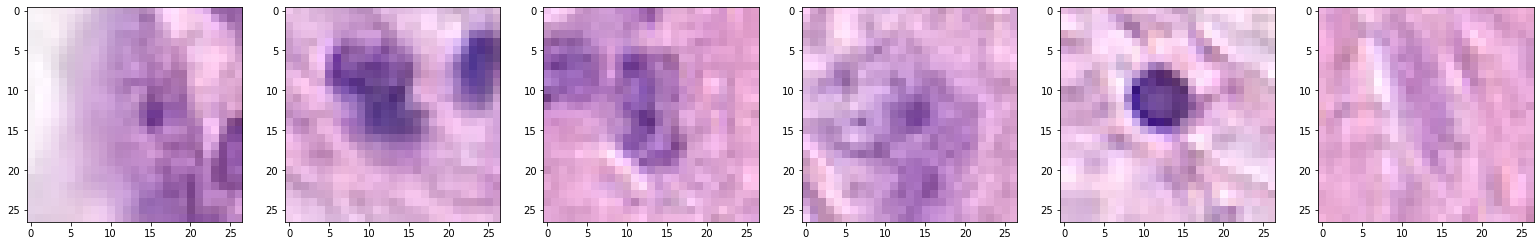

In [11]:
r_inx = np.random.choice(100, 6)
rand_data = total_data.loc[r_inx,'ImageName']

plt.figure(figsize=(27,27))
for i, image_path in enumerate(rand_data):
  im1 = Image.open(image_path)
  im = np.asarray(Image.open(image_path))
  pixel_values = list(im1.getdata())
  plt.subplot(1,6,i+1)
  plt.imshow(im)
plt.show()

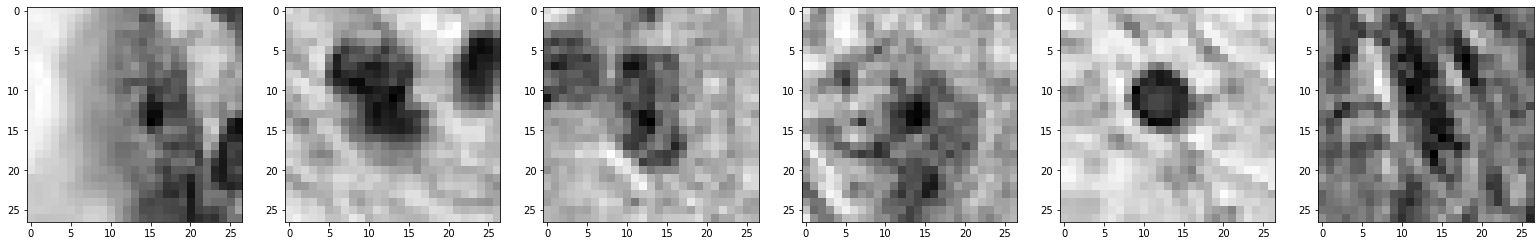

In [12]:
plt.figure(figsize=(27,27))
for i, image_path in enumerate(rand_data):
  im1 = Image.open(image_path).convert("L")
  im = np.asarray(Image.open(image_path).convert("L"))
  pixel_values = list(im1.getdata())
  plt.subplot(1,6,i+1)
  plt.imshow(im, cmap='gray')
plt.show()

Total Non Cancerous instances:  13211
Total Cancerous instances:  7069


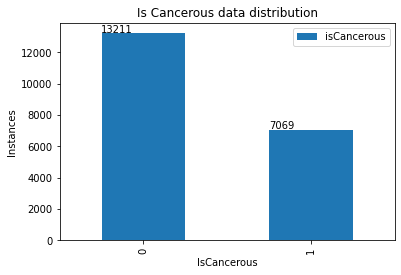

In [13]:
x = pd.DataFrame(total_data['isCancerous'].value_counts())
y = x.plot.bar(title = "Is Cancerous data distribution", xlabel = "IsCancerous", ylabel = "Instances")

for p in y.patches:
    y.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))


print("Total Non Cancerous instances: ",total_data['isCancerous'].value_counts()[0] )
print("Total Cancerous instances: ",total_data['isCancerous'].value_counts()[1] )


It can also be observed that the cell type information has class imbalance. 

Total cell type name with count: 
 epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: cellTypeName, dtype: int64


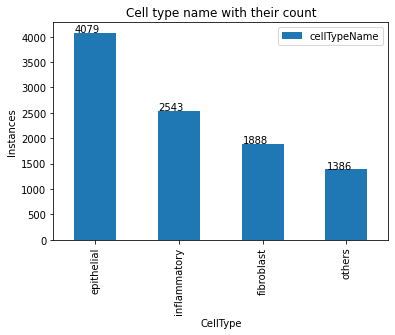

In [14]:
x = pd.DataFrame(data['cellTypeName'].value_counts())
y = x.plot.bar(title = "Cell type name with their count", xlabel = "CellType", ylabel = "Instances")

for p in y.patches:
    y.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))


print("Total cell type name with count: \n", data['cellTypeName'].value_counts())

Each patientID is associated with their own total image instances, hence the data is not evenly distributed. We can see that some patients have instances around 700 images where as some have images as close to 0. 

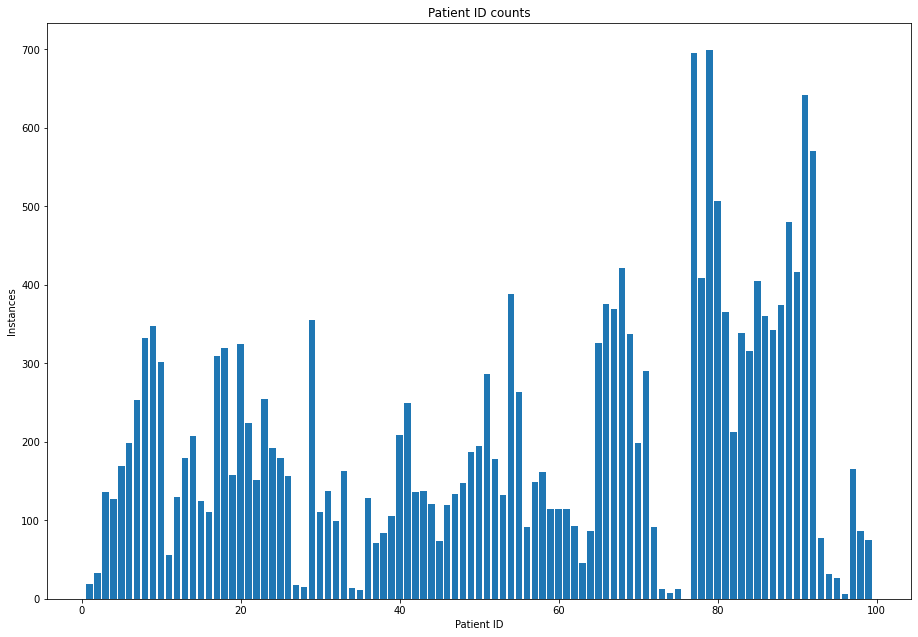

In [15]:
y = total_data['patientID'].value_counts().sort_index()
fig = plt.figure()
ax = fig.add_axes([0,0,2,2], title = "Patient ID counts", xlabel = "Patient ID", ylabel = "Instances")
ax.bar(y.index,y.values)
plt.show()

Since, we will be modelling using the grayscale model in the later part of this project, hence, we check the RGB overlap histograms in order to check the inference weights. From the below graphs an overlapping histograms can be observed for RGB images and the structure of the histogram overlap for grayscale and RGB is almost the same with similar range values.

(0.0, 256.0)

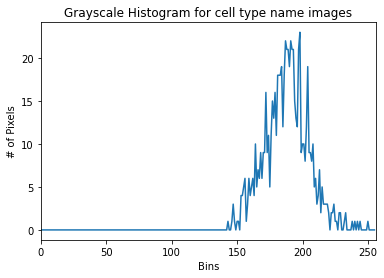

In [16]:
for i, image_path in enumerate(rand_data):
  im2 = np.asarray(Image.open(image_path))

gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
plt.figure()
plt.title("Grayscale Histogram for cell type name images")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
plt.plot(hist)
plt.xlim([0, 256])

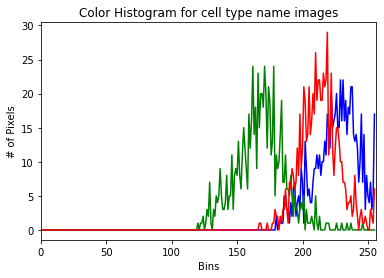

In [17]:
chans = cv2.split(im2)
colors = ("b", "g", "r")
plt.figure()
plt.title("Color Histogram for cell type name images")
plt.xlabel("Bins")
plt.ylabel("# of Pixels")
features = []
# loop over the image channels
for (chan, color) in zip(chans, colors):
	# create a histogram for the current channel and
	# concatenate the resulting histograms for each
	# channel
	hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
	features.extend(hist)
	# plot the histogram
	plt.plot(hist, color = color)
	plt.xlim([0, 256])

# **Binary Classification for `isCancerous`** <a class="anchor" id="6"></a>

In this chuck we will implement base line and incremental model to classify cancerous and non cancerous cell types, we will compare and contrast the approaches used. 

## **Data Splitting** <a class="anchor" id="6.1"></a>

We split the data into training, testing and validation split. We use our training data to train our Convolutional Neural Network model, validation data to see how our model performs on this unseen data and perform the necessary hyper parameter tuning to make the model generalize well to unseen test data. The test data will be used at the end to test how well our model has generalised to this new unseen data.

- We then check the 'is cancerous' and 'non cancerous' value counts for train, validation and test data. 
- We have made sure that the patientID 76 is not present in the dataset to avoid misleading information. 
- We have randomly divided the data to have 70% patients in train, 20% in Validation and 10% for Testing. 
- These divisions are based on patientID and not on total instances, hence, we make sure that the patients in training are not used in validation and testing, thus reducing data leakage.


In [18]:
listID = []

for i in range(1,100):
  listID.append(i)
listID
listID.pop(75)

76

In [19]:
from sklearn.model_selection import train_test_split
train,test =  train_test_split(listID, test_size=0.3, random_state=99)
val,testing = train_test_split(test, test_size=0.33, random_state=99)
TrainData = total_data[total_data['patientID'].isin(train)]
ValData = total_data[total_data['patientID'].isin(val)]
TestingData = total_data[total_data['patientID'].isin(testing)]
print("TrainData shape: ",TrainData.shape)
print("ValData shape: ",ValData.shape)
print("TestData shape: ",TestingData.shape)
ValData.reset_index(drop=True,inplace=True)
TrainData.reset_index(drop=True,inplace=True)
TestingData.reset_index(drop=True,inplace=True)
TrainData['isCancerous'] = TrainData['isCancerous'].astype('str')
ValData['isCancerous'] = ValData['isCancerous'].astype('str')

TrainData shape:  (14022, 6)
ValData shape:  (4441, 6)
TestData shape:  (1817, 6)


It can be observed that there are approximately 14 thousand instances in the Training Data, 4 thousand in validation and approx 2 thousand in testing. There are 68 patients in training set, 20 patients in Validation and 10 patients for testing. 

We have made sure that the algorithm learns evenly on each class. 

In [20]:
print("Patient ID counts for Train",TrainData['patientID'].nunique())
print("Value Counts for isCancerous in training\n",TrainData['isCancerous'].value_counts())
print("----------------------------------------------------------------------------------------")
print("Patient ID counts for Validation",ValData['patientID'].nunique())

print("Value Counts for isCancerous in Validating\n",ValData['isCancerous'].value_counts())
print("----------------------------------------------------------------------------------------")
print("Patient ID counts for Test",TestingData['patientID'].nunique())

print("Value Counts for isCancerous in Testing\n",TestingData['isCancerous'].value_counts())
print("----------------------------------------------------------------------------------------")

Patient ID counts for Train 68
Value Counts for isCancerous in training
 0    9004
1    5018
Name: isCancerous, dtype: int64
----------------------------------------------------------------------------------------
Patient ID counts for Validation 20
Value Counts for isCancerous in Validating
 0    2934
1    1507
Name: isCancerous, dtype: int64
----------------------------------------------------------------------------------------
Patient ID counts for Test 10
Value Counts for isCancerous in Testing
 0    1273
1     544
Name: isCancerous, dtype: int64
----------------------------------------------------------------------------------------


## **Data Augmentation** <a class="anchor" id="6.2"></a>

**Setting up a plotting function**

After we have identified the train/test/validation splits we are ready to do the experiments. We define the layers in our network. While develpoing deep neural networks, we can use the learning curves to identify what needs to be done next. This simple function is used to plot the learning curve of a Neural network training process.

In [21]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='F1-score'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylim([0.0, 1.0])
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

**Reading Images with ImageDataGenerator with basic Augmentation.**

We now read the data from keras image data generator. ImageDataGenerator helps to augment images with the help of different techniques like roattion, standardization, shifts, brightness change and more. One of the main advantages of this is it provides real time data augmentation. that is it generstes augmented iamges while your model is training.

We rescale the data by dividing by 255 and then by choosing data_format as 'channels_last' we are converting image into format the format of [batch_size,image Height, image Width, No of channels].

'flow_from_dataframe()' helps to read the images and labels from the dataframe. Since we our performing a categorical task we set the class_mode to categorical and set the batch_size to 32, this value can also be changed if required.

In the following chunck we have augmented the images into grayscale format. 

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=TrainData,
        directory='./',
        x_col="ImageName",
        y_col="isCancerous",
        color_mode="grayscale",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=ValData,
        directory='./',
        x_col="ImageName",
        y_col="isCancerous",
        color_mode="grayscale",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

Found 14022 validated image filenames belonging to 2 classes.
Found 4441 validated image filenames belonging to 2 classes.


## **Base Model Implementation** <a class="anchor" id="6.3"></a>

First step in building any model is deciding any error metric and as we can see our target class `isCancerous` is not balanced we will go with `f1_score` as our metric and Sparse categorical cross entropy as our loss function. 

We are considering a VGG architecture in building our model but, with some changes in our layers and parameters. Our model takes inspiration from the VGG architecture but with some changes. 

Here we first start with 2 Conv2D layers first with basic hyper parameters. We use relu as our activation step function as this will output the input directly if it is positive, otherwise, it will output zero. Relu also eliminates the vanishing gradient problem. Padding is set to same and we have used he_normal as the kernel initializer. 

We are using a maxpooling layer then with a stride of 2*2 to avoid overfitting and achieving great performance.

In [23]:
# This model is inspired by the VGG imagenet architecture, hence it has multiple CONV2d layers and some MaxPooling layers. 

Binary_BaselineModel= tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same',input_shape=(27, 27, 1)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #Multilayer Pervceptions
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2),
])


In [24]:
opt = tf.keras.optimizers.Adam(lr=0.0001)
Binary_BaselineModel.compile(optimizer=opt,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics='sparse_categorical_accuracy')

In [25]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_generator.classes),
                                                 train_generator.classes)

In [26]:
class_weight_dict = dict(enumerate(class_weights))

In [27]:
history_BaselineBinary = Binary_BaselineModel.fit_generator(train_generator, validation_data = validation_generator, epochs=20, verbose=1, class_weight=class_weight_dict)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/20
439/439 [==============================] - 38s 15ms/step - loss: 0.5276 - sparse_categorical_accuracy: 0.7395 - val_loss: 0.5128 - val_sparse_categorical_accuracy: 0.7485
Epoch 2/20
439/439 [==============================] - 6s 14ms/step - loss: 0.4475 - sparse_categorical_accuracy: 0.7908 - val_loss: 0.4877 - val_sparse_categorical_accuracy: 0.7708
Epoch 3/20
439/439 [==============================] - 6s 14ms/step - loss: 0.4151 - sparse_categorical_accuracy: 0.8103 - val_loss: 0.4313 - val_sparse_categorical_accuracy: 0.8095
Epoch 4/20
439/439 [==============================] - 6s 14ms/step - loss: 0.3969 - sparse_categorical_accuracy: 0.8232 - val_loss: 0.3754 - val_sparse_categorical_accuracy: 0.8372
Epoch 5/20
439/439 [==============================] - 6s 14ms/step - loss: 0.3847 - sparse_categorical_accuracy: 0.8292 - val_loss: 0.438

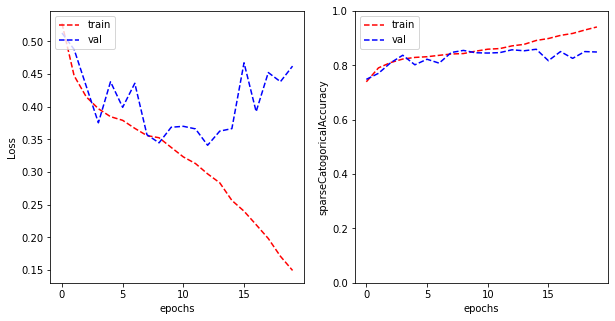

In [28]:
plot_learning_curve(history_BaselineBinary.history['loss'], history_BaselineBinary.history['val_loss'], 
                    history_BaselineBinary.history['sparse_categorical_accuracy'], history_BaselineBinary.history['val_sparse_categorical_accuracy'], 
                    metric_name='sparseCatogoricalAccuracy')

From the above graphs a clear case of overfitting is observed. Hence we can assume that although greyscale model works good with CNN, however in our data corpus the model might not perform well, hence we shift our approach to include RGB images. 


In [29]:
# Setting up place holders
y_hat_all = list()
y_all = list()
filenames = validation_generator.filenames
N_images = len(filenames)
batches = 0

In [33]:
# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in validation_generator:
        y_hat = Binary_BaselineModel.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        #y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

In [34]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
f1_score(y_all, y_hat_all, average='macro')

0.8349606763403306

In [35]:
target = ['0','1']
print(classification_report(y_all,y_hat_all,target_names=target))

              precision    recall  f1-score   support

           0       0.91      0.86      0.88      2934
           1       0.75      0.83      0.79      1507

    accuracy                           0.85      4441
   macro avg       0.83      0.84      0.83      4441
weighted avg       0.85      0.85      0.85      4441



## **Incremental model and hyperparameter tuning** <a class="anchor" id="6.4"></a>

Based on the approach used in our baseline model, we can see that the model is largely overfitting. To reduce this we have used the following approach: 
- We have changed the Data Augmentation to include the images in their orignal RGB matrices. 
- The Regularization parameters are used to decrease the overfitting which can be caused due to back propagation. 
- Including dropout layers is an excellent approach since drop out works by randomly setting the outgoing edges of hidden units to 0 at each update of the training phase. 
- Further, we have chosen 'Adam()' optimizer which works good with our non-linear activation function 'Relu' and which is an advanced version of Stochastic Gradient Descent algorithm used for the loss optimization.

Getting the right hyper-parameters was an interative process of trying numerous parameters, changing the convolution layers as well as the MLP layers along with the evaluation metrics. 



In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
TrainData['isCancerous'] = TrainData['isCancerous'].astype('str')
ValData['isCancerous'] = ValData['isCancerous'].astype('str')
TestingData['isCancerous'] = TestingData['isCancerous'].astype('str')
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=TrainData,
        directory='./',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=ValData,
        directory='./',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='sparse')

testing_generator = test_datagen.flow_from_dataframe(
      dataframe=TestingData,
      directory='./',
      x_col="ImageName",
      y_col='isCancerous',
      target_size=(27,27),
      batch_size=batch_size,
      class_mode='sparse')

Found 14022 validated image filenames belonging to 2 classes.
Found 4441 validated image filenames belonging to 2 classes.
Found 1817 validated image filenames belonging to 2 classes.


In [42]:
reg_lambda = 0.01

Final_Binary = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(2),
])

In [43]:
opt = tf.keras.optimizers.Adam(lr=0.001)
Final_Binary.compile(optimizer=opt,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics='sparse_categorical_accuracy')

In [44]:
history = Final_Binary.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=1, class_weight=class_weight_dict)

Epoch 1/50
439/439 [==============================] - 7s 14ms/step - loss: 1.7945 - sparse_categorical_accuracy: 0.7508 - val_loss: 0.8088 - val_sparse_categorical_accuracy: 0.8183
Epoch 2/50
439/439 [==============================] - 5s 12ms/step - loss: 0.7272 - sparse_categorical_accuracy: 0.8263 - val_loss: 0.6320 - val_sparse_categorical_accuracy: 0.8503
Epoch 3/50
439/439 [==============================] - 5s 13ms/step - loss: 0.6378 - sparse_categorical_accuracy: 0.8387 - val_loss: 0.8112 - val_sparse_categorical_accuracy: 0.7305
Epoch 4/50
439/439 [==============================] - 6s 13ms/step - loss: 0.5951 - sparse_categorical_accuracy: 0.8403 - val_loss: 0.6658 - val_sparse_categorical_accuracy: 0.7917
Epoch 5/50
439/439 [==============================] - 6s 13ms/step - loss: 0.5620 - sparse_categorical_accuracy: 0.8477 - val_loss: 0.4822 - val_sparse_categorical_accuracy: 0.8820
Epoch 6/50
439/439 [==============================] - 6s 13ms/step - loss: 0.5330 - sparse_cate

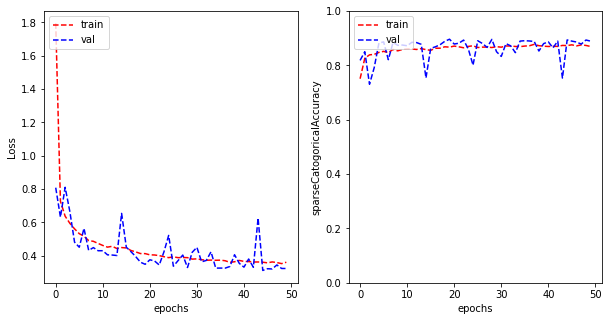

In [45]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 
                    metric_name='sparseCatogoricalAccuracy')

## **Performance Evaluation** <a class="anchor" id="6.5"></a>

From the below plots we can observe that a better learning model. Now, since we have implemented a better model, lets talk about its performance and the metrics used to measure the same.

- Two main graphs are used to evaluate the model on train and validation data. These graphs show the decrease in losses and the increase in the accuracy score. 
- We can still observe some oscillations for the validation set, but overall the performance of the model is good. 
- The loss function used to evaluate the model is `SparseCategoricalCrossEntropy` defined in the keras library. Since we are using this model to perform the binary classificaiton, hence, we are going with this loss function. 
- We have calculated the epoch with default step size and used 50 epochs to run our model. Epoch values can be increase, however, consistency in the model outputs can be observed. 
- Overall in the performance evaluation of the final model we can state that the performance of the model is increase after fine tuning by using the RGB images, F1_score metrics, regluarizations and dropout layers. 



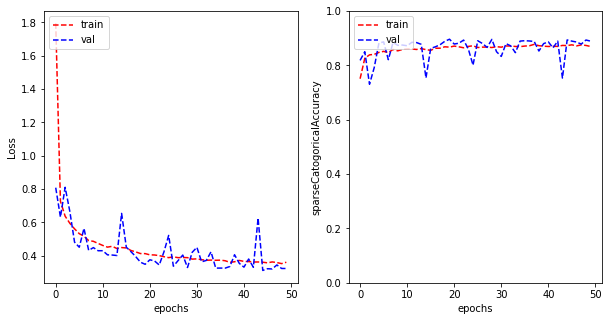

In [46]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['sparse_categorical_accuracy'], history.history['val_sparse_categorical_accuracy'], 
                    metric_name='sparseCatogoricalAccuracy')

In [47]:
# Setting up place holders
y_hat_all = list()
y_all = list()
filenames = validation_generator.filenames
N_images = len(filenames)
batches = 0

In [48]:
# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in validation_generator:
        y_hat = Final_Binary.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        #y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

In [49]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
f1_score(y_all, y_hat_all, average='macro')

0.8785499884425141

In [50]:
target = ['0','1']
print(classification_report(y_all,y_hat_all,target_names=target))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      2934
           1       0.81      0.88      0.84      1507

    accuracy                           0.89      4441
   macro avg       0.87      0.89      0.88      4441
weighted avg       0.89      0.89      0.89      4441



## **Predictions** <a class="anchor" id="6.6"></a>

Since we have evaluated our model and now we know that the best model is the VGG architecture with defined convolutional and MLP layers, we can use this data on the testing data to generate predictions and see the performance of the model on unseen data. 

To do so we have used the following steps:
- Since tfa addons that we are using in the training takes parameters for each epoch, we cannot use the same metrics to validate on test data as we will be having the test information as predictions in an array. 
- Hence, to do so we will be using the sklearn metrics F1 score to predict and observe the score. 
- We will first set place holders and iterate them through each batch of generated images from the test generator and then calculate F1 score for all the batches. 
- We will then send that information to the sklearn metrics to observe the overall F1 score. 

In [51]:
# Setting up place holders
y_hat_all = list()
y_all = list()
filenames = testing_generator.filenames
N_images = len(filenames)
batches = 0

In [53]:
# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in testing_generator:
        y_hat = Final_Binary.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

In [54]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
f1_score(y_all, y_hat_all, average='macro')

0.9099919528965589

On the unseen data, we can observe an *F1 score of 0.91 that is 91%.*

# **Multiclass Classification for `cellType`** <a class="anchor" id="7"></a>

In this section we have implemented the multiclass classification using Convolutional Nueral Networks. This model takes its own data inputs and is trained separately from the previous model. Although the model might have similar architechture that is VGG, but the training and feature engineering is performed independently. 

In this chuck we aim to classify the cellType information containing 4 types of cells:
  - Fibroblast
  - Inflammatory
  - Epithelial
  - Others



## **Data Splitting** <a class="anchor" id="7.1"></a>

Since we know that the multiclass classification information is only given in the main data, hence, we use only that infromation to train and evaluate our model. 

In [64]:
data = pd.read_csv("./data_labels_mainData.csv")

In [65]:
MulticlassList = []

for i in range(1,61):
  MulticlassList.append(i)

In [66]:
from sklearn.model_selection import train_test_split
trainmul,testtemp =  train_test_split(MulticlassList, test_size=0.3, random_state=99)
valmul,testingmul = train_test_split(testtemp, test_size=0.33, random_state=99)
Mul_TrainData = data[data['patientID'].isin(trainmul)]
Mul_ValData = data[data['patientID'].isin(valmul)]
Mul_TestingData = data[data['patientID'].isin(testingmul)]
print("TrainData shape: ",Mul_TrainData.shape)
print("ValData shape: ",Mul_ValData.shape)
print("TestData shape: ",Mul_TestingData.shape)
Mul_ValData.reset_index(drop=True,inplace=True)
Mul_TrainData.reset_index(drop=True,inplace=True)
Mul_TestingData.reset_index(drop=True,inplace=True)
Mul_TrainData['ImageName'] = './patch_images/'+Mul_TrainData['ImageName'].astype(str)
Mul_ValData['ImageName'] = './patch_images/'+Mul_ValData['ImageName'].astype(str)
Mul_TestingData['ImageName'] = './patch_images/'+Mul_TestingData['ImageName'].astype(str)
Mul_TrainData['cellType'] = Mul_TrainData['cellType'].astype('str')
Mul_ValData['cellType'] = Mul_ValData['cellType'].astype('str')
Mul_TestingData['cellType'] = Mul_TestingData['cellType'].astype('str')

TrainData shape:  (6696, 6)
ValData shape:  (2111, 6)
TestData shape:  (1089, 6)


In [67]:
print("Cell Type distributions on Training\n",Mul_TrainData['cellType'].value_counts())
print("------------------------------------------")
print("Cell Type distributions on Validation\n",Mul_ValData['cellType'].value_counts())
print("------------------------------------------")
print("Cell Type distributions on Testing\n",Mul_TestingData['cellType'].value_counts())
print("------------------------------------------")

Cell Type distributions on Training
 2    2748
1    1683
0    1328
3     937
Name: cellType, dtype: int64
------------------------------------------
Cell Type distributions on Validation
 2    980
1    391
0    372
3    368
Name: cellType, dtype: int64
------------------------------------------
Cell Type distributions on Testing
 1    469
2    351
0    188
3     81
Name: cellType, dtype: int64
------------------------------------------


## **Data Augmentation** <a class="anchor" id="7.2"></a>

- We need to read the images for multiclass prediction into training and validation data. ImageDataGenerator helps to augment images with the help of different techniques like roattion, standardization, shifts, brightness change and more. One of the main advantages of this is it provides real time data augmentation. that is it generstes augmented iamges while your model is training. 

- We rescale the data by dividing by 255 and then by choosing data_format as 'channels_last' we are converting image into format the format of [batch_size,image Height, image Width, No of channels]. 'flow_from_dataframe()' helps to read the images and labels from the dataframe. Since we our performing a categorical task we set the class_mode to categorical and set the batch_size to 32, this value can also be changed if required.

In [70]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=Mul_TrainData,
        directory='./',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        random_state = 99,
        batch_size=batch_size,
        class_mode='sparse')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=Mul_ValData,
        directory='./',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        random_state = 99,
        batch_size=batch_size,
        class_mode='sparse')

Testing_generator = test_datagen.flow_from_dataframe(
        dataframe=Mul_TestingData,
        directory='./',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27,27),
        random_state = 99,
        batch_size=batch_size,
        class_mode='sparse')


Found 6696 validated image filenames belonging to 4 classes.
Found 2111 validated image filenames belonging to 4 classes.
Found 1089 validated image filenames belonging to 4 classes.


## **Base Model Implementation** <a class="anchor" id="7.3"></a>

- The first step in building a model is to set up an evaluation metric. As our target label (cell type) is not balanced we will use f1_score as our metric and sparse categorical cross entropy as our loss function. 

- We are considering a VGG architecture in building our model but, with some changes in our layers and parameters. Our model takes inspiration from the VGG architecture but with some changes. 

- We will start our base model with 3 Con2D layers. We will be using relu as our activation function due to the same reasons as mentioned above.

- We are using a maxpooling layer then with a stride of 2*2 to avoid overfitting and achieving great performance. 

- We are using dropout to set random inputs to 0, this helps in preventing overfitting.
 
- We then check the plots for loss and accuracy score and see if the model is overfitting.

In [71]:
model_VGG_Mul = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(4),
])

We now choose `Adam()` optimizer with a laerning rate of 0.001 which works good with our non-linear activation function `Relu`. Finally, we fit the model and let it run for 50 epochs and check how our model performs. We then check the learning curve to see if our model has been overfitted.

In [73]:
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=0.001)
model_VGG_Mul.compile(optimizer=opt,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics='sparse_categorical_accuracy')


In [74]:
history_multiclass = model_VGG_Mul.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=1)

Epoch 1/50
210/210 [==============================] - 4s 15ms/step - loss: 1.0477 - sparse_categorical_accuracy: 0.5750 - val_loss: 0.8028 - val_sparse_categorical_accuracy: 0.6599
Epoch 2/50
210/210 [==============================] - 3s 12ms/step - loss: 0.7874 - sparse_categorical_accuracy: 0.6898 - val_loss: 0.8414 - val_sparse_categorical_accuracy: 0.6660
Epoch 3/50
210/210 [==============================] - 3s 12ms/step - loss: 0.7138 - sparse_categorical_accuracy: 0.7186 - val_loss: 0.8284 - val_sparse_categorical_accuracy: 0.6845
Epoch 4/50
210/210 [==============================] - 3s 12ms/step - loss: 0.6837 - sparse_categorical_accuracy: 0.7309 - val_loss: 0.8572 - val_sparse_categorical_accuracy: 0.6637
Epoch 5/50
210/210 [==============================] - 3s 13ms/step - loss: 0.6619 - sparse_categorical_accuracy: 0.7436 - val_loss: 0.7371 - val_sparse_categorical_accuracy: 0.7063
Epoch 6/50
210/210 [==============================] - 3s 12ms/step - loss: 0.5961 - sparse_cate

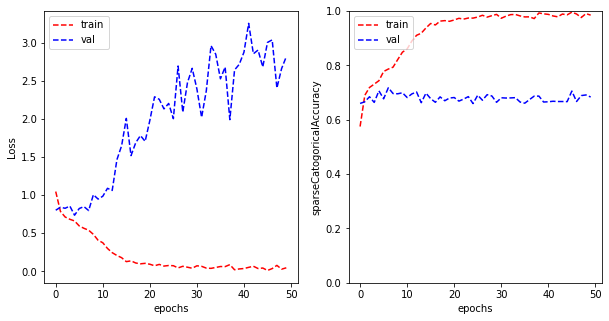

In [75]:
plot_learning_curve(history_multiclass.history['loss'], history_multiclass.history['val_loss'], 
                    history_multiclass.history['sparse_categorical_accuracy'], history_multiclass.history['val_sparse_categorical_accuracy'], 
                    metric_name='sparseCatogoricalAccuracy')

From the plots obtained above we can see that our model has been overfitted to a great extent. This needs to be handled using various techniques such as regularization, data augmentation and so on. 

## **Incremental Changes and Hyperparameter Tuning** <a class="anchor" id="7.3"></a>

There are various incremental changes that can be performed in order to increase the performance of any CNN models. Some of those include using regularizations, batch normalizations, Data Augmentations, Dropout layers etc. 

For this particular model we have made following changes in order to know the perfect hyperparameters that reduce overfitting and increase the performance of the model. 

In the below chunk we are using the data augmentations by rotating the images, changing the width range, height range and the brightness ranges. These have been tested with various parameters to find the perfect ones for the model. Random state has been defined in order to have the same images everytime the kernel re-initializes.  


In [83]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=Mul_TrainData,
        directory='./',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        random_state = 99,
        batch_size=batch_size,
        class_mode='sparse')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=Mul_ValData,
        directory='./',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        random_state = 99,
        batch_size=batch_size,
        class_mode='sparse')

Testing_generator = test_datagen.flow_from_dataframe(
        dataframe=Mul_TestingData,
        directory='./',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27,27),
        random_state = 99,
        batch_size=batch_size,
        class_mode='sparse')

Found 6696 validated image filenames belonging to 4 classes.
Found 2111 validated image filenames belonging to 4 classes.
Found 1089 validated image filenames belonging to 4 classes.


In the below chunk we have implemented the VGG model for multiclass, we have defined following parameters:
- regularizations as 0.01 
- Dropout 0.2
- Padding = same (This is done to retain similar image sizes)


In [84]:
reg_lambda = 0.01

model_VGG_Mul_Final = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # #VGG block 3
    # tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
    #                        kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    # tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
    #                        kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    # tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(4),
])

A learning rate of 0.001 has been specifies, this restricts the learning of the algorithm to be too shallow or too deep. Since our features are deep we are using high learning rate. 

In [85]:
opt = tf.keras.optimizers.Adam(lr=0.001)
model_VGG_Mul_Final.compile(optimizer=opt,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics='sparse_categorical_accuracy')

In [87]:
history_multiclass = model_VGG_Mul_Final.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=1)

Epoch 1/50
210/210 [==============================] - 7s 30ms/step - loss: 2.4045 - sparse_categorical_accuracy: 0.5252 - val_loss: 1.5891 - val_sparse_categorical_accuracy: 0.6097
Epoch 2/50
210/210 [==============================] - 6s 29ms/step - loss: 1.4681 - sparse_categorical_accuracy: 0.6441 - val_loss: 1.2898 - val_sparse_categorical_accuracy: 0.6518
Epoch 3/50
210/210 [==============================] - 6s 30ms/step - loss: 1.2462 - sparse_categorical_accuracy: 0.6700 - val_loss: 1.1864 - val_sparse_categorical_accuracy: 0.6480
Epoch 4/50
210/210 [==============================] - 6s 30ms/step - loss: 1.1713 - sparse_categorical_accuracy: 0.6744 - val_loss: 1.1531 - val_sparse_categorical_accuracy: 0.6480
Epoch 5/50
210/210 [==============================] - 6s 30ms/step - loss: 1.1294 - sparse_categorical_accuracy: 0.6841 - val_loss: 1.1179 - val_sparse_categorical_accuracy: 0.6594
Epoch 6/50
210/210 [==============================] - 6s 30ms/step - loss: 1.0805 - sparse_cate

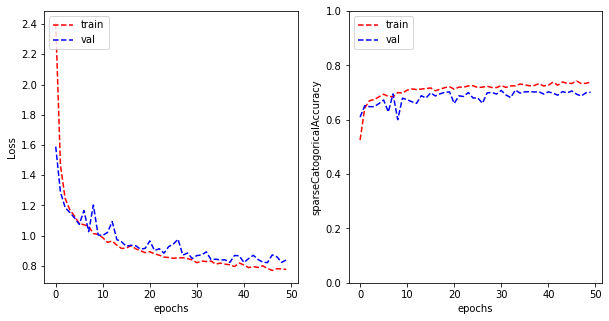

In [89]:
plot_learning_curve(history_multiclass.history['loss'], history_multiclass.history['val_loss'], 
                    history_multiclass.history['sparse_categorical_accuracy'], history_multiclass.history['val_sparse_categorical_accuracy'], 
                    metric_name='sparseCatogoricalAccuracy')

## **Performance Evaluation** <a class="anchor" id="7.4"></a>

The evaluation of the algorithm is done using sparse accuracy metrics and `sparseCategoricalCrossEntropy`. Since there exists a class imbalance, F1 score can be used to evaluate the algorithm. 
Categorical cross entropy is used since the model is used to classify 4 classes of outputs. 

- In the below graph 50 epocs were used to validate the model.
- The loss function categorical cross entropy can be seen decreasing, hence, we can say that the model is learning. 
- There are some oscillations, but that can be handled with more data. 

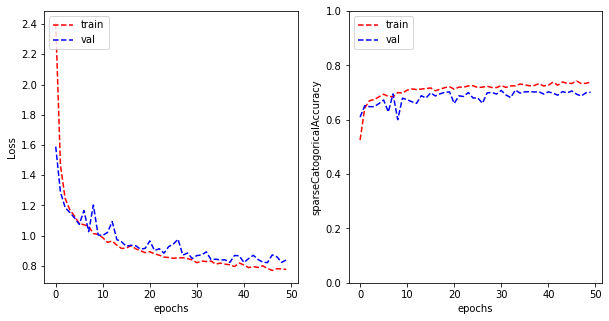

In [91]:
plot_learning_curve(history_multiclass.history['loss'], history_multiclass.history['val_loss'], 
                    history_multiclass.history['sparse_categorical_accuracy'], history_multiclass.history['val_sparse_categorical_accuracy'], 
                    metric_name='sparseCatogoricalAccuracy')

In [92]:
y_hat_all = list()
y_all = list()
filenames = validation_generator.filenames
N_images = len(filenames)
batches = 0

In [93]:
# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in validation_generator:
        y_hat = model_VGG_Mul_Final.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        #y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

In [94]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
f1_score(y_all, y_hat_all, average='macro')

0.6015462180599839

In [95]:
target = ['0','1','2','3']
print(classification_report(y_all,y_hat_all,target_names=target))

              precision    recall  f1-score   support

           0       0.58      0.51      0.54       372
           1       0.57      0.70      0.63       391
           2       0.79      0.94      0.86       980
           3       0.68      0.26      0.38       368

    accuracy                           0.70      2111
   macro avg       0.65      0.60      0.60      2111
weighted avg       0.69      0.70      0.68      2111



## **Predictions** <a class="anchor" id="7.5"></a>

In this chunck we will be predicting the model performance on unseen data. This is implemented as the same process as we did in section 6. 

In [96]:
y_hat_all = list()
y_all = list()
filenames = Testing_generator.filenames
N_images = len(filenames)
batches = 0

In [98]:
# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in Testing_generator:
        y_hat = model_VGG_Mul_Final.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

In [99]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
f1_score(y_all, y_hat_all, average='macro')


0.6079581571074542

An F1 score of 0.60 that is 60% can be observed on unseen data. 

# **Transfer Learning on Unlabelled Data** <a class="anchor" id="8"></a>


At this point in this project we have developed 2 models, one for binary classification on the `isCancerous` information and the other for `cellType` classification. 
We know that the `cellType` model only works on 60 patients as the class labels of the remaining patients are not available.

Hence we aim to perform transfer learning from a learn't model on the unlabelled data. 
This can be done using the following steps: 
- We know that the CNN model for `isCancerous` classification has been trained on all 98 patients, however, it has classfied only the binary values. 
- So, going ahead we will use the weights this model has learn't and change the MLP layers in order to use it to be trained on the cellType information. 
- To do so we will freeze the weights and change the trainable parameters to non-trainable. 
- Then we will add the MLP layers to the already learn't model and observe it performance on the `cellType` class. 
- We will compare this model with our previous model and check the performances if it is improving. 

In [101]:
# Cloning the model and all the parameters for transfer learning. 
model_TL = tf.keras.models.clone_model(Final_Binary, input_tensors=None, clone_function=None)
model_TL.summary(
    
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 6, 6, 128)        

In [103]:
model_TL.pop()

In [104]:
model_TL.add(tf.keras.layers.Dense(4))

## Importing and splitting data for multiclass

In [111]:
data = pd.read_csv("./data_labels_mainData.csv")
MulticlassList = []

for i in range(1,61):
  MulticlassList.append(i)

In [112]:
from sklearn.model_selection import train_test_split
trainmul,testtemp =  train_test_split(MulticlassList, test_size=0.3, random_state=99)
valmul,testingmul = train_test_split(testtemp, test_size=0.33, random_state=99)
Mul_TrainData = data[data['patientID'].isin(trainmul)]
Mul_ValData = data[data['patientID'].isin(valmul)]
Mul_TestingData = data[data['patientID'].isin(testingmul)]
print("TrainData shape: ",Mul_TrainData.shape)
print("ValData shape: ",Mul_ValData.shape)
print("TestData shape: ",Mul_TestingData.shape)
Mul_ValData.reset_index(drop=True,inplace=True)
Mul_TrainData.reset_index(drop=True,inplace=True)
Mul_TestingData.reset_index(drop=True,inplace=True)
Mul_TrainData['ImageName'] = './patch_images/'+Mul_TrainData['ImageName'].astype(str)
Mul_ValData['ImageName'] = './patch_images/'+Mul_ValData['ImageName'].astype(str)
Mul_TestingData['ImageName'] = './patch_images/'+Mul_TestingData['ImageName'].astype(str)
Mul_TrainData['cellType'] = Mul_TrainData['cellType'].astype('str')
Mul_ValData['cellType'] = Mul_ValData['cellType'].astype('str')
Mul_TestingData['cellType'] = Mul_TestingData['cellType'].astype('str')

TrainData shape:  (6696, 6)
ValData shape:  (2111, 6)
TestData shape:  (1089, 6)


## Image Generators

In [113]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=Mul_TrainData,
        directory='./',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        random_state = 99,
        batch_size=batch_size,
        class_mode='sparse')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=Mul_ValData,
        directory='./',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        random_state = 99,
        batch_size=batch_size,
        class_mode='sparse')

Testing_generator = test_datagen.flow_from_dataframe(
        dataframe=Mul_TestingData,
        directory='./',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27,27),
        random_state = 99,
        batch_size=batch_size,
        class_mode='sparse')

Found 6696 validated image filenames belonging to 4 classes.
Found 2111 validated image filenames belonging to 4 classes.
Found 1089 validated image filenames belonging to 4 classes.


In [114]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [115]:
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=0.0001)
model_TL.compile(optimizer=opt,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics='sparse_categorical_accuracy')

In [116]:
history_TL = model_TL.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=1)

Epoch 1/50
210/210 [==============================] - 7s 31ms/step - loss: 7.7588 - sparse_categorical_accuracy: 0.4948 - val_loss: 6.3420 - val_sparse_categorical_accuracy: 0.5893
Epoch 2/50
210/210 [==============================] - 6s 30ms/step - loss: 5.5919 - sparse_categorical_accuracy: 0.6096 - val_loss: 4.8531 - val_sparse_categorical_accuracy: 0.6234
Epoch 3/50
210/210 [==============================] - 6s 30ms/step - loss: 4.4203 - sparse_categorical_accuracy: 0.6565 - val_loss: 3.9930 - val_sparse_categorical_accuracy: 0.6746
Epoch 4/50
210/210 [==============================] - 6s 30ms/step - loss: 3.7292 - sparse_categorical_accuracy: 0.6732 - val_loss: 3.5654 - val_sparse_categorical_accuracy: 0.6267
Epoch 5/50
210/210 [==============================] - 6s 30ms/step - loss: 3.2649 - sparse_categorical_accuracy: 0.6798 - val_loss: 3.0700 - val_sparse_categorical_accuracy: 0.6708
Epoch 6/50
210/210 [==============================] - 6s 30ms/step - loss: 2.9591 - sparse_cate

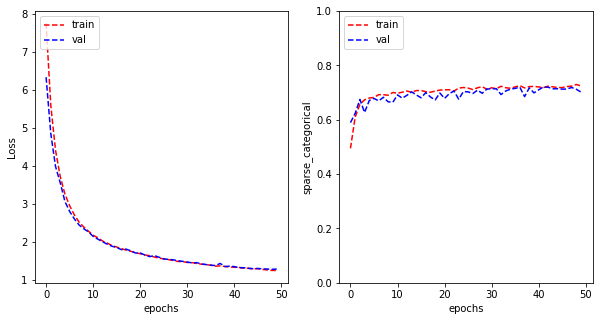

In [117]:
plot_learning_curve(history_TL.history['loss'], history_TL.history['val_loss'], 
                    history_TL.history['sparse_categorical_accuracy'], history_TL.history['val_sparse_categorical_accuracy'], 
                    metric_name='sparse_categorical')

## Prediction on Unseen data

In [118]:
y_hat_all = list()
y_all = list()
filenames = Testing_generator.filenames
N_images = len(filenames)
batches = 0

In [120]:
# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in Testing_generator:
        y_hat = model_TL.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

In [121]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
f1_score(y_all, y_hat_all, average='macro')

0.667416246151066

In [122]:
target = ['0','1','2','3']
print(classification_report(y_all,y_hat_all,target_names=target))

              precision    recall  f1-score   support

           0       0.69      0.79      0.73       188
           1       0.83      0.93      0.88       470
           2       0.92      0.81      0.86       351
           3       0.34      0.14      0.20        80

    accuracy                           0.81      1089
   macro avg       0.69      0.67      0.67      1089
weighted avg       0.80      0.81      0.80      1089



**Based on the above outputs of the transfer learning model following observations can be made**
- It can be observed that the weights are learn't weights are transfered from the `isCancerous` model to the multiclass model. 
- Since the model has learn't all its parameters, it perfoms better on the less data. 
- This technique can be used to improve the performances of the models where there is very less data that can be used to train the model. 
- Less data may create oscillations and unstability of the model, we can observe that the transfer learning model is stable and less oscillating. Hence the performances are better. 
- Transfer learning is a huge advantage at the data corpus on which the model has been already trained might contain instances that are not inclusive of the existing information. Hence this can be a better performing model. 
- The final scores can we get after the Transfer learning is around 67% F1score

# **Summary and Conclusion** <a class="anchor" id="10"></a>

In this project we have used supervised learning algorithms to classify the `isCancerous` and `cellType` classification models. The metrics used for predictions are F1 scores and sparseCategoricalAccuracy is used as the loss function. 
- It can be seen that the model with total 98 patients performs the best with highest score. However, when data decreases and the classification classes increases, the performance of the model goes down. 
- The transfer learning model is the best one with minimum oscillations and maximum stability. 